In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import spacy
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from collections import Counter
import re
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [54]:
data=pd.read_csv('Dataset - final_merged_file_shuffled.csv')
data.head()

,title,content,classification
0,"Ajith Kumar Announces His Own Racing Team, Wel...",Tamil actor and professional racer Ajith Kumar...,0.0
1,Devi Navarathri Celebrations Start from Oct. 3,Kakinada:The famous Bala Tripura Sundari Devi ...,0.0
2,Former MVP may be 'even better fit' for Philli...,Jackson Roberts If one issue has plagued the P...,0.0
3,AI transforming healthcare: ISB study,Hyderabad: Artificial Intelligence (AI) is set...,0.0
4,"Know All About Asthma: Severity For Children, ...","Know All About Asthma: Severity For Children, ...",0.0


In [ ]:
# Fill empty values in 'classification' column with 0 (or 1 if appropriate)
data['classification'] = data['classification'].fillna(1).astype(int)
Y = data['classification']

# Fill empty values in 'title' and 'content' columns with an empty string
data['title'] = data['title'].fillna('')
data['content'] = data['content'].fillna('')


1.Tokenization and N-grams

In [ ]:
stopwords = set([
     'the', 'and', 'is', 'in', 'to', 'with', 'a', 'on', 'of', 'it', 'he', "you'd", 'your',
    'yours', 'yourself', 'yourselves', 'him', 'his', 'himself', 'she', "she's", 'her',
    'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'an', 'but', 'if', 'or',
    'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
    'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
    'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',
    'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
    'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't",
    'should', "should've", 'now', 'd', 'll', 're', 've', 'y', 'ain', 'aren', "aren't",
    'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
    "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
    'needn', "needn't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't"
])

def tokenize_text(text):
    # Split by whitespace and convert to lowercase
    words = text.lower().split()
    # Filter out non-alphabetic words and stopwords
    tokens = [word for word in words if word.isalpha() and word not in stopwords]
    return tokens

# Apply tokenization
data['tokens'] = data['content'].apply(lambda x: tokenize_text(str(x)))

# N-gram generation
def generate_ngrams(tokens, n=2):
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngrams.append(tuple(tokens[i:i + n]))
    return ngrams


data['bigrams'] = data['tokens'].apply(lambda x: generate_ngrams(x, 2))


Bi Gram table

In [ ]:
import json
from collections import Counter

# Calculate bigram probabilities
def calculate_bigram_probabilities(tokens):
    unigram_counts = Counter(tokens)
    bigram_counts = Counter(zip(tokens, tokens[1:]))
    bigram_probabilities = {
        (w1, w2): count / unigram_counts[w1] for (w1, w2), count in bigram_counts.items()
    }
    return bigram_probabilities

# Save bigram probabilities in JSON format
def save_bigram_as_json(bigram_probabilities, filename):
    word_bigram_map = {}
    for (w1, w2), prob in bigram_probabilities.items():
        if prob > 0:
            word_bigram_map.setdefault(w1, {})[w2] = prob
    with open(filename, "w", encoding="utf-8") as file:
        json.dump(word_bigram_map, file, ensure_ascii=False, indent=2)
        
all_tokens = [token for tokens in data['tokens'] for token in tokens]

# Calculate bigram probabilities for the English tokens
bigram_probabilities = calculate_bigram_probabilities(all_tokens)

# Save the bigram probabilities as csv file
save_bigram_as_json(bigram_probabilities, "english_bigram_probabilities.csv")


2. Named Entity Recognition (NER)

In [ ]:
people_names = {"john", "maria", "ajith", "robert", "elizabeth taylor"}  
organization_names = {"google", "microsoft", "tesla", "microsoft corporation"}  
locations = {"new york", "paris", "london", "hyderabad", "los angeles"}  
date_keywords = {
    "january", "february", "march", "october", "2023", "today", "tomorrow",
    "monday", "tuesday", "wednesday", "2024"
}  

def extract_entities(text):
    entities = []

    lower_text = text.lower()

    for phrase in people_names:
        if phrase in lower_text:
            entities.append((phrase, "PERSON"))
    for phrase in organization_names:
        if phrase in lower_text:
            entities.append((phrase, "ORG"))
    for phrase in locations:
        if phrase in lower_text:
            entities.append((phrase, "GPE"))
    for phrase in date_keywords:
        if phrase in lower_text:
            entities.append((phrase, "DATE"))

    words = lower_text.split()
    for word in words:
        if word in people_names:
            entities.append((word, "PERSON"))
        elif word in organization_names:
            entities.append((word, "ORG"))
        elif word in locations:
            entities.append((word, "GPE"))
        elif word in date_keywords:
            entities.append((word, "DATE"))

    entities = list(set(entities))

    return entities

data['entities'] = data['content'].apply(lambda x: extract_entities(str(x)))

# Show the extracted entities
# print(data[['title', 'entities']])


3. Part-of-Speech (POS) Tagging

In [ ]:
noun_suffixes = ['tion', 'ness', 'ment', 'ity', 'ship', 'dom', 'ism', 'ist', 'ance', 'ence']
verb_suffixes = ['ing', 'ed', 'ize', 'ify', 'ate', 'en', 's']
adjective_suffixes = ['ous', 'able', 'ible', 'ful', 'less', 'ic', 'al', 'ive']
adverb_suffixes = ['ly', 'ward', 'wise']
pronouns = ['he', 'she', 'it', 'they', 'we', 'i', 'you', 'us']
proper_nouns = ['john', 'maria', 'london'] 

# Auxiliary verbs for improved tagging of common auxiliary or helping verbs
auxiliary_verbs = ['is', 'am', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'can', 'could', 'will', 'would', 'shall', 'should', 'may', 'might', 'must']

def pos_tagging(text):
    words = text.split()
    pos_tags = []

    for word in words:
        # Default tag
        tag = "UNKNOWN"

        # Check for pronoun
        if word.lower() in pronouns:
            tag = "PRONOUN"
        # Check for auxiliary verb
        elif word.lower() in auxiliary_verbs:
            tag = "AUX_VERB"
        # Check if word is capitalized (possible proper noun)
        elif word[0].isupper() and word.lower() not in proper_nouns:
            tag = "PROPER_NOUN"
        # Check for noun suffixes
        elif any(word.endswith(suffix) for suffix in noun_suffixes):
            tag = "NOUN"
        # Check for verb suffixes
        elif any(word.endswith(suffix) for suffix in verb_suffixes):
            tag = "VERB"
        # Check for adjective suffixes
        elif any(word.endswith(suffix) for suffix in adjective_suffixes):
            tag = "ADJECTIVE"
        # Check for adverb suffixes
        elif any(word.endswith(suffix) for suffix in adverb_suffixes):
            tag = "ADVERB"

        # Append tagged word
        pos_tags.append((word, tag))

    return pos_tags

# Apply POS tagging to the 'content' column
data['pos_tags'] = data['content'].apply(lambda x: pos_tagging(str(x)))

#results
print(data[['title', 'pos_tags']])


                                                   title  \
0      Ajith Kumar Announces His Own Racing Team, Wel...   
1         Devi Navarathri Celebrations Start from Oct. 3   
2      Former MVP may be 'even better fit' for Philli...   
3                  AI transforming healthcare: ISB study   
4      Know All About Asthma: Severity For Children, ...   
...                                                  ...   
13372  Donald J. Trump’s 10 Point Plan to Put America...   
13373  Queen Elizabeth's spectacular collection of ti...   
13374  Queen Camilla set to be presented as Prince Ha...   
13375  Taxpayers Association demands government to ta...   
13376  Israeli Man Arrested Over Iranian-Backed Plot ...   

                                                pos_tags  
0      [(Tamil, PROPER_NOUN), (actor, UNKNOWN), (and,...  
1      [(Kakinada:The, PROPER_NOUN), (famous, VERB), ...  
2      [(Jackson, PROPER_NOUN), (Roberts, PROPER_NOUN...  
3      [(Hyderabad:, PROPER_NOUN), (Artific

4. TF-IDF Vectorization

In [ ]:
from collections import Counter, defaultdict
import math
from scipy.sparse import csr_matrix

# Step 1: Tokenization
def tokenize(text):
    words = text.split()
    unigrams = words
    bigrams = [f"{words[i]} {words[i+1]}" for i in range(len(words) - 1)]
    return unigrams + bigrams

def build_tf_df_matrix(documents, max_features=5000):
    tf_matrix = []

    df_counts = defaultdict(int)

    for doc in documents:
        tokens = tokenize(doc)
        tf_counts = Counter(tokens)
        tf_matrix.append(tf_counts)

        # Update document frequency counts
        for term in tf_counts:
            df_counts[term] += 1

    sorted_terms = sorted(df_counts.items(), key=lambda x: -x[1])[:max_features]
    vocabulary = {term: idx for idx, (term, _) in enumerate(sorted_terms)}

    return tf_matrix, df_counts, vocabulary

def compute_tfidf(tf_matrix, df_counts, vocabulary, num_docs):
    rows, cols, values = [], [], []

    for i, tf_counts in enumerate(tf_matrix):
        for term, tf in tf_counts.items():
            if term in vocabulary:
                # Calculate TF and IDF
                tf_value = tf / sum(tf_counts.values())
                df = df_counts[term]
                idf_value = math.log(num_docs / (df + 1)) + 1  
                # Store TF-IDF value
                rows.append(i)
                cols.append(vocabulary[term])
                values.append(tf_value * idf_value)

    tfidf_sparse_matrix = csr_matrix((values, (rows, cols)), shape=(len(tf_matrix), len(vocabulary)))

    return tfidf_sparse_matrix

documents = data['content'].apply(str).tolist()

tf_matrix, df_counts, vocabulary = build_tf_df_matrix(documents)
X_tfidf = compute_tfidf(tf_matrix, df_counts, vocabulary, len(documents))

vocabulary_dict = vocabulary

print("TF-IDF Matrix shape:", X_tfidf.shape)
print("Vocabulary:", vocabulary_dict)
print(X_tfidf)


TF-IDF Matrix shape: (13377, 5000)
Vocabulary: {'the': 0, 'to': 1, 'of': 2, 'and': 3, 'in': 4, 'a': 5, 'on': 6, 'for': 7, 'The': 8, 'is': 9, 'with': 10, 'that': 11, 'of the': 12, 'by': 13, 'in the': 14, 'from': 15, 'at': 16, 'as': 17, 'has': 18, 'was': 19, 'be': 20, 'have': 21, 'an': 22, 'to the': 23, 'are': 24, 'this': 25, 'it': 26, 'not': 27, 'been': 28, 'also': 29, 'their': 30, 'will': 31, 'for the': 32, 'who': 33, 'which': 34, 'on the': 35, 'he': 36, 'said': 37, 'his': 38, 'but': 39, 'were': 40, 'after': 41, 'they': 42, 'had': 43, 'about': 44, 'In': 45, 'at the': 46, 'or': 47, 'all': 48, 'one': 49, 'and the': 50, 'over': 51, 'out': 52, 'more': 53, 'up': 54, 'A': 55, 'with the': 56, 'when': 57, 'in a': 58, 'into': 59, 'only': 60, 'from the': 61, 'to be': 62, 'that the': 63, 'can': 64, 'would': 65, 'its': 66, 'two': 67, 'other': 68, 'He': 69, 'by the': 70, 'first': 71, 'get': 72, 'than': 73, 'It': 74, 'just': 75, 'we': 76, 'is a': 77, 'being': 78, 'This': 79, 'has been': 80, 'people'

In [63]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, data['classification'], test_size=0.2, random_state=42)

5. Exploratory Data Analysis (EDA)

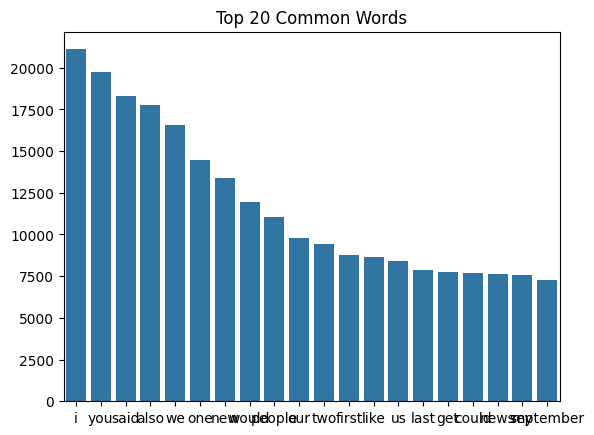

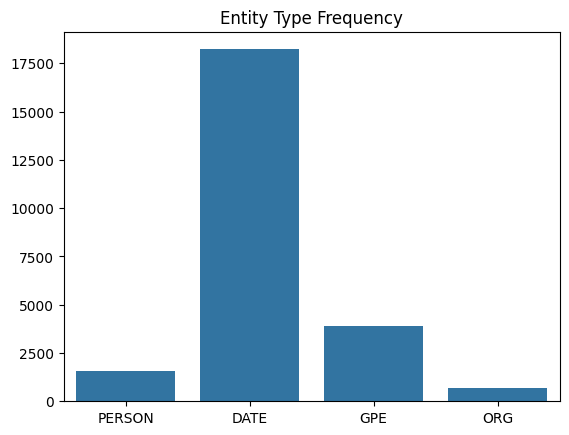

In [64]:
# Word Frequency Plot
all_words = [word for tokens in data['tokens'] for word in tokens]
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Plotting
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
plt.title("Top 20 Common Words")
plt.show()

# NER Frequency
entity_labels = [label[1] for entities in data['entities'] for label in entities]
entity_freq = Counter(entity_labels)
sns.barplot(x=list(entity_freq.keys()), y=list(entity_freq.values()))
plt.title("Entity Type Frequency")
plt.show()


6. Feature Engineering and Selection

In [65]:
# Add POS and entity counts
data['entity_count'] = data['entities'].apply(lambda x: len(x))
data['noun_count'] = data['pos_tags'].apply(lambda x: sum(1 for tag in x if tag[1] == "NOUN"))
data['verb_count'] = data['pos_tags'].apply(lambda x: sum(1 for tag in x if tag[1] == "VERB"))


In [66]:
data.head(2)

,title,content,classification,tokens,bigrams,entities,pos_tags,entity_count,noun_count,verb_count
0,"Ajith Kumar Announces His Own Racing Team, Wel...",Tamil actor and professional racer Ajith Kumar...,0,"[tamil, actor, professional, racer, ajith, kum...","[(tamil, actor), (actor, professional), (profe...","[(ajith, PERSON)]","[(Tamil, PROPER_NOUN), (actor, UNKNOWN), (and,...",1,1,62
1,Devi Navarathri Celebrations Start from Oct. 3,Kakinada:The famous Bala Tripura Sundari Devi ...,0,"[famous, bala, tripura, sundari, devi, navarat...","[(famous, bala), (bala, tripura), (tripura, su...","[(october, DATE)]","[(Kakinada:The, PROPER_NOUN), (famous, VERB), ...",1,0,17


7. Model Training and Evaluation

Class Weights: {0: 0.6468205996131529, 1: 2.2027583367641004}
Accuracy with Default Threshold: 0.9603886397608371
Classification Report with Default Threshold:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2059
           1       0.92      0.91      0.91       617

    accuracy                           0.96      2676
   macro avg       0.95      0.94      0.94      2676
weighted avg       0.96      0.96      0.96      2676


Accuracy with Adjusted Threshold (0.3): 0.9581464872944694
Classification Report with Adjusted Threshold (0.3):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2059
           1       0.90      0.92      0.91       617

    accuracy                           0.96      2676
   macro avg       0.94      0.94      0.94      2676
weighted avg       0.96      0.96      0.96      2676

Logistic Regression Confusion Matrix:
[[1997   62]
 [  50  567]]


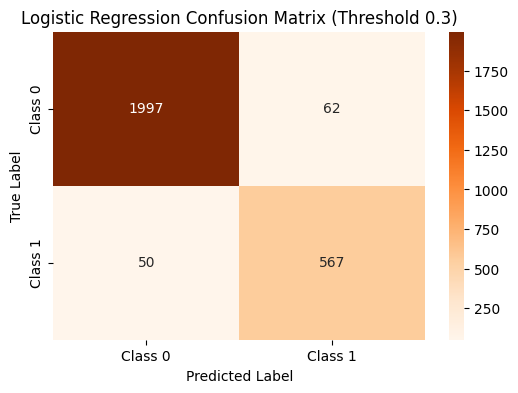

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)


model = LogisticRegression(class_weight='balanced') 
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]


threshold = 0.3  
y_pred_threshold = (y_proba > threshold).astype(int)




print("\nAccuracy with Adjusted Threshold (0.3):", accuracy_score(y_test, y_pred_threshold))
print("Classification Report with Adjusted Threshold (0.3):")
print(classification_report(y_test, y_pred_threshold))


logreg_cm = confusion_matrix(y_test, y_pred_threshold)
print("Logistic Regression Confusion Matrix:")
print(logreg_cm)

# Visualizing the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.title("Logistic Regression Confusion Matrix (Threshold 0.3)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


8. Cross-Validation and Hyperparameter Tuning

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

K-Nearest Neighbors Accuracy: 0.6880916791230692
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      3099
           1       0.41      0.89      0.57       915

    accuracy                           0.69      4014
   macro avg       0.68      0.76      0.66      4014
weighted avg       0.83      0.69      0.71      4014

K-Nearest Neighbors Confusion Matrix:
[[1944 1155]
 [  97  818]]


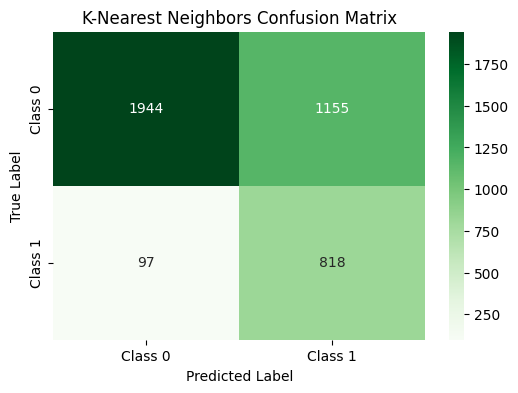

Best KNN Model Accuracy: 0.6988041853512705
Best KNN Confusion Matrix:
[[1998 1101]
 [ 108  807]]


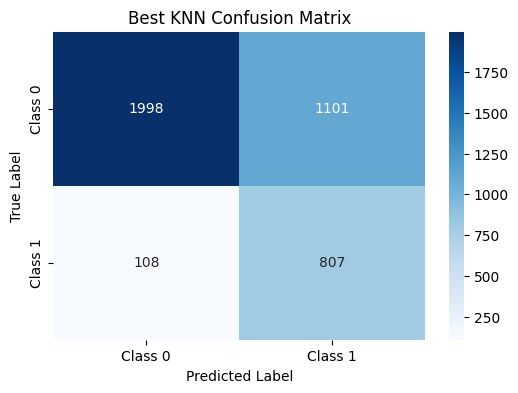

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, data['classification'], test_size=0.3, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print("K-Nearest Neighbors Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

knn_cm = confusion_matrix(y_test, y_pred_knn)
print("K-Nearest Neighbors Confusion Matrix:")
print(knn_cm)

plt.figure(figsize=(6, 4))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Greens', xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.title("K-Nearest Neighbors Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

param_grid_knn = {'n_neighbors': [3, 5, 7, 10]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_knn.fit(X_train, y_train)

best_knn_model = grid_knn.best_estimator_
y_pred_best_knn = best_knn_model.predict(X_test)

print("Best KNN Model Accuracy:", accuracy_score(y_test, y_pred_best_knn))

best_knn_cm = confusion_matrix(y_test, y_pred_best_knn)
print("Best KNN Confusion Matrix:")
print(best_knn_cm)

plt.figure(figsize=(6, 4))
sns.heatmap(best_knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.title("Best KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Prediction

In [ ]:
import numpy as np

def preprocess_article(article, stopwords):
    tokens = [word.lower() for word in article.split() if word.isalpha() and word.lower() not in stopwords]
    return ' '.join(tokens)

def predict_article(article, model, tfidf_vectorizer, stopwords):
    processed_article = preprocess_article(article, stopwords)

    article_vector = tfidf_vectorizer.transform([processed_article])

    prediction = model.predict(article_vector)

    result = "True" if prediction[0] == 0 else "False"
    return result

stopwords = set([
    "the", "is", "in", "and", "to", "has", "a", "of", "for", "on", "with",
    "as", "by", "that", "an", "are", "it", "this", "from", "at", "be", "or"
])

article=" November 2015 Ads THE BIG CHILL: Kill Fat Cells Instantly Just by Freezing Them! You’ll Never Believe How it Work For most people, fat bulges are something they don’t want. It makes our thighs jiggle, our clothes fit tight and look bad, and typically lingers despite our torturous attempts to eliminate it. Too much of it increases our risk for certain illnesses like heart disease and type 2 diabetes, so for decades researchers have looked for ways to reduce it. Humans have two types of fat: white fat & brown fat, and understanding the differences between the two, can help people lose weight. “White fat” is the thin layer of blubber we see on the human belly. backs of arms and on the thighs. This particular fat acts as a thermal insulator, that keeps body temperatures stable. LEARN MORE: “Brown fat,” on the other hand, is less abundant in the body and creates heat, rather than trapping it like white fat does. Brown fat actually warms a cold body by burning energy or calories. White fat however, can take on brown fat characteristics, with the resulting product called “beige fat.” This process is called “browning.” Because beige and brown fat are able to burn calories, they are a positive force for weight loss, while an excess of white fat is associated with weight gain and obesity. According to Dr. Philip A. Kern, a researcher of the University of Kentucky School of Medicine, browning fat tissue would be an excellent defense against obesity, as it would make the body burn extra calories rather than converting them into fatty tissue. Where Do We Have Brown Fat? Brown fat can be difficult to study because it is hard to find in adults, and typically found in unpredictable locations in the body, and not always in the same place on every person. There’s a region in the neck and the shoulders, where you typically find it, but again not on everybody. In a recent study, brown fat was found in the chests and down the spines of a group of healthy young men, along with places in the abdomen"

best_model = best_knn_model  
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_vectorizer.fit(data['content'].apply(str).tolist()) 

# Prediction
prediction_result = predict_article(article, best_model, tfidf_vectorizer, stopwords)
print("Prediction:", prediction_result)


Prediction: True


In [71]:
import pickle

with open('./model/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open('./model/knn_model.pkl', 'wb') as f:
    pickle.dump(best_knn_model, f)